# gpOptimizer Single-Task Test

This is the new test for fvgp version 4.0.0 and later.

In [1]:
##first install the newest version of fvgp
#!pip install gpcam==8.0.0

## Setup

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from gpcam import GPOptimizer
import time


%load_ext autoreload
%autoreload 2

In [3]:
from itertools import product
x_pred1D = np.linspace(0,1,1000).reshape(-1,1)

## Data

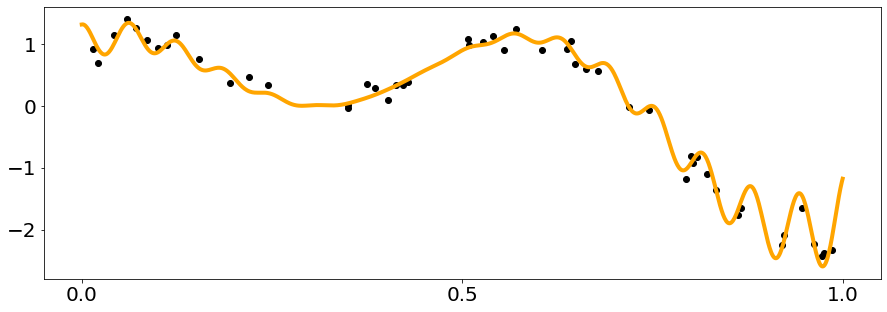

In [4]:
x = np.linspace(0,600,1000)
def f1(x):
    return np.sin(5. * x) + np.cos(10. * x) + (2.* (x-0.4)**2) * np.cos(100. * x)
 
x_data = np.random.rand(50) 
y_data = f1(x_data) + (np.random.rand(len(x_data))-0.5) * 0.5

plt.figure(figsize = (15,5))
plt.xticks([0.,0.5,1.0])
plt.yticks([-2,-1,0.,1])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(x_pred1D,f1(x_pred1D), color = 'orange', linewidth = 4)
plt.scatter(x_data,y_data, color = 'black')

## Customizing a Gaussian Process

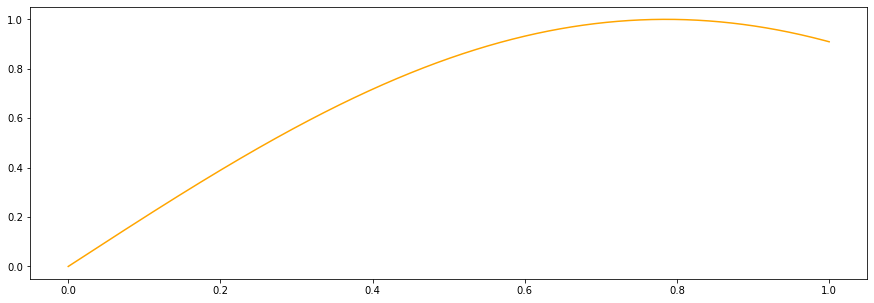

In [5]:
def my_noise(x,hps,obj):
    #This is a simple noise function, but can be arbitrarily complex using many hyperparameters.
    #The noise function always has to return a matrix, because the noise can have covariances.
    return np.diag(np.zeros((len(x))) + hps[2])

#stationary
def skernel(x1,x2,hps,obj):
    #The kernel follows the mathematical definition of a kernel. This
    #means there is no limit to the variety of kernels you can define.
    d = obj._get_distance_matrix(x1,x2)
    return hps[0] * obj.matern_kernel_diff1(d,hps[1])


def meanf(x, hps, obj):
    #This ios a simple mean function but it can be arbitrarily complex using many hyperparameters.
    return np.sin(hps[3] * x[:,0])
#it is a good idea to plot the prior mean function to make sure we did not mess up
plt.figure(figsize = (15,5))
plt.plot(x_pred1D,meanf(x_pred1D, np.array([1.,1.,5.0,2.]), None), color = 'orange', label = 'task1')

## Initialization and different training options

In [6]:
my_gpo = GPOptimizer(x_data,y_data,
            init_hyperparameters = np.ones((4))/10.,  # we need enough of those for kernel, noise and prior mean functions
            noise_variances=np.ones(y_data.shape) * 0.01, #provding noise variances and a noise function will raise a warning 
            compute_device='cpu', 
            gp_kernel_function=skernel, 
            gp_kernel_function_grad=None, 
            gp_mean_function=meanf, 
            gp_mean_function_grad=None,
            gp_noise_function=my_noise,
            normalize_y=False,
            sparse_mode=False,
            gp2Scale = False,
            store_inv=False, 
            ram_economy=False, 
            args=None,
            )


hps_bounds = np.array([[0.01,10.], #signal variance for the kernel
                       [0.01,10.], #length scale for the kernel
                       [0.001,0.1],  #noise
                       [0.01,1.]  #mean
                      ])

my_gpo.tell(x_data, y_data, noise_variances=np.ones(y_data.shape) * 0.01)
print("Standard Training")
my_gpo.train(hps_bounds)
print("Global Training")
my_gpo.train(hps_bounds, method='global')
print("hps: ", my_gpo.get_hyperparameters())
print("Local Training")
my_gpo.train(hps_bounds, method='local')
print(my_gpo.get_hyperparameters())
print("MCMC Training")
my_gpo.train(hps_bounds, method='mcmc', max_iter=1000)
print("HGDL Training")
my_gpo.train(hps_bounds, method='hgdl', max_iter=10)


Standard Training
Global Training
hps:  [2.50715541 0.42087715 0.02781208 0.01000445]
Local Training
[2.50715534 0.42087745 0.02780835 0.01000445]
MCMC Training
HGDL Training


### More advanced: Asynchronous training
Train asynchronously on a remote server or locally. 
You can also start a bunch of different trainings on different computers.
This training will continue without any signs of life until you call 'my_gp1.stop_training(opt_obj)'

In [7]:
opt_obj = my_gpo.train_async(hps_bounds)

In [8]:
for i in range(10):
    time.sleep(2)
    my_gpo.update_hyperparameters(opt_obj)
    print(my_gpo.hyperparameters)
    print("")

[2.50507341 0.42074935 0.02780841 0.01      ]

[2.50507341 0.42074935 0.02780841 0.01      ]

[2.50507341 0.42074935 0.02780841 0.01      ]

[2.50507341 0.42074935 0.02780841 0.01      ]

[2.50507341 0.42074935 0.02780841 0.01      ]

[2.50507341 0.42074935 0.02780841 0.01      ]

[2.50507341 0.42074935 0.02780841 0.01      ]

[2.50507341 0.42074935 0.02780841 0.01      ]

[2.50507341 0.42074935 0.02780841 0.01      ]

[2.50507341 0.42074935 0.02780841 0.01      ]



In [9]:
my_gpo.stop_training(opt_obj)

## The Result

46.69305698647005
-0.13453365290945465


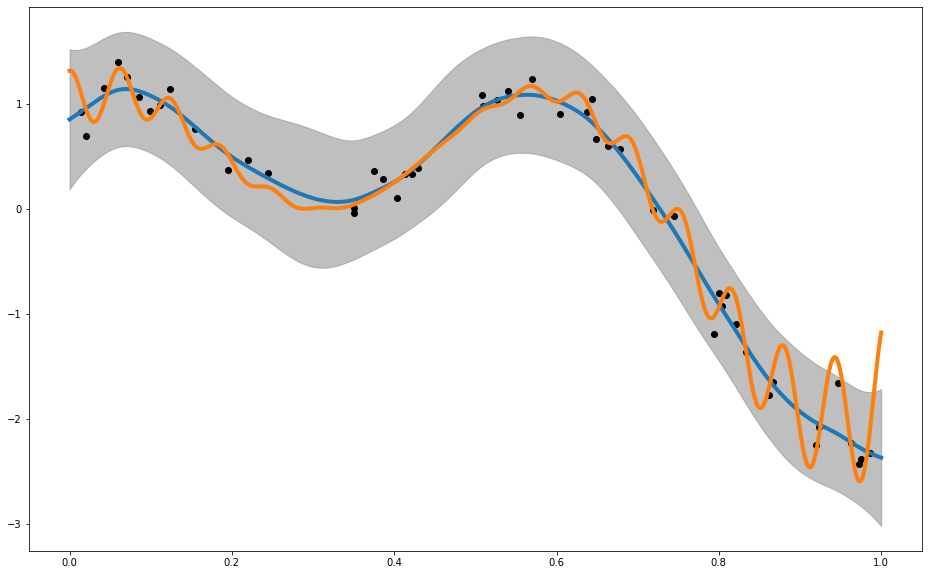

In [10]:
#let's make a prediction
x_pred = np.linspace(0,1,1000)

mean1 = my_gpo.posterior_mean(x_pred.reshape(-1,1))["f(x)"]
var1 =  my_gpo.posterior_covariance(x_pred.reshape(-1,1), variance_only=False, add_noise=True)["v(x)"]
plt.figure(figsize = (16,10))
plt.plot(x_pred,mean1, label = "posterior mean", linewidth = 4)
plt.plot(x_pred1D,f1(x_pred1D), label = "latent function", linewidth = 4)
plt.fill_between(x_pred, mean1 - 3. * np.sqrt(var1), mean1 + 3. * np.sqrt(var1), alpha = 0.5, color = "grey", label = "var")
plt.scatter(x_data,y_data, color = 'black')


##looking at some validation metrics
print(my_gpo.rmse(x_pred1D,f1(x_pred1D)))
print(my_gpo.crps(x_pred1D,f1(x_pred1D)))

In [11]:
#available acquisition function:
acquisition_functions = ["variance","covariance","relative information entropy","relative information entropy set",
                        "ucb","lcb","maximum","minimum","gradient","expected improvement",
                         "PI", "target probability", "total correlation"]

Acquisition function  variance  creates an output of shape (1000,)
Acquisition function  covariance  creates an output of shape (1,)
Some acquisition function return a scalar score for the entirety of points. Here:  covariance
Acquisition function  relative information entropy  creates an output of shape (1,)
Some acquisition function return a scalar score for the entirety of points. Here:  relative information entropy
Acquisition function  relative information entropy set  creates an output of shape (1000,)
Acquisition function  ucb  creates an output of shape (1000,)
Acquisition function  lcb  creates an output of shape (1000,)
Acquisition function  maximum  creates an output of shape (1000,)
Acquisition function  minimum  creates an output of shape (1000,)
Acquisition function  gradient  creates an output of shape (1000,)
Acquisition function  expected improvement  creates an output of shape (1000,)
Acquisition function  PI  creates an output of shape (1000,)
Acquisition function  t

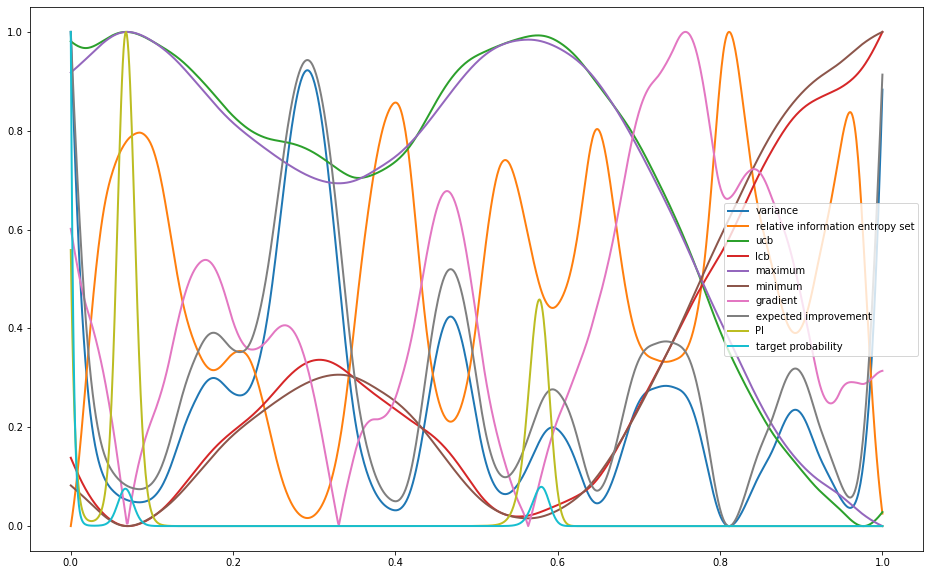

In [12]:
plt.figure(figsize=(16,10))
for acq_func in acquisition_functions:
    res = my_gpo.evaluate_acquisition_function(x_pred, acquisition_function=acq_func,
                                args={'a': 1.5, 'b':2.} #this is only for acq_func = 'target probability'
                                              )
    print("Acquisition function ",acq_func," creates an output of shape",res.shape)
    if len(res)==len(x_pred):
        res = res - np.min(res)
        res = res/np.max(res)
        plt.plot(x_pred,res, label = acq_func, linewidth = 2)
    else: print("Some acquisition function return a scalar score for the entirety of points. Here: ", acq_func)
plt.legend()
plt.show()


## Now let's see what the next best point to measure is
with several optimization methods and acquisition functions

In [13]:
#let's test the asks:
bounds = np.array([[0.0,1.0]])
for acq_func in acquisition_functions:
    for method in ["global","local","hgdl"]:
        print("Acquisition function ", acq_func," and method ",method)
        new_suggestion = my_gpo.ask(bounds, acquisition_function=acq_func, 
                                    method=method,args={'a': 1.5, 'b':2.}, max_iter = 2,)
        print("led to new suggestion: \n", new_suggestion)
        print("")


Acquisition function  variance  and method  global
led to new suggestion: 
 {'x': array([[0.27914578]]), 'f(x)': array([0.01940647]), 'opt_obj': None}

Acquisition function  variance  and method  local
led to new suggestion: 
 {'x': array([[0.21419978]]), 'f(x)': array([0.00891067]), 'opt_obj': None}

Acquisition function  variance  and method  hgdl
led to new suggestion: 
 {'x': array([[0.73302432]]), 'f(x)': array([0.00919561]), 'opt_obj': <hgdl.hgdl.HGDL object at 0x7f397d4c7a30>}

Acquisition function  covariance  and method  global
led to new suggestion: 
 {'x': array([[0.28968639]]), 'f(x)': array([0.14229079]), 'opt_obj': None}

Acquisition function  covariance  and method  local
led to new suggestion: 
 {'x': array([[0.16265741]]), 'f(x)': array([0.09575695]), 'opt_obj': None}

Acquisition function  covariance  and method  hgdl
led to new suggestion: 
 {'x': array([[0.29153761]]), 'f(x)': array([0.14236084]), 'opt_obj': <hgdl.hgdl.HGDL object at 0x7f397da03280>}

Acquisition fu

In [14]:
#here we can test other options of the ask() command
bounds = np.array([[0.0,1.0]])
new_suggestion = my_gpo.ask(bounds, acquisition_function="total_correlation", method="global",
                            max_iter=10, n = 5, info = True)
print(new_suggestion)

differential_evolution step 1: f(x)= 20.8583
differential_evolution step 2: f(x)= 20.693
differential_evolution step 3: f(x)= 19.9275
differential_evolution step 4: f(x)= 19.9275
differential_evolution step 5: f(x)= 19.9275
differential_evolution step 6: f(x)= 19.9275
differential_evolution step 7: f(x)= 19.9275
differential_evolution step 8: f(x)= 19.9275
differential_evolution step 9: f(x)= 19.9275
differential_evolution step 10: f(x)= 19.9275
{'x': array([[0.48778732],
       [0.70062112],
       [0.30979147],
       [0.46823526],
       [0.88593419]]), 'f(x)': array([19.92745748]), 'opt_obj': None}


In [17]:
bounds = np.array([[0.0,1.0]])

#You can even start an ask() search asynchronously and check back later what was found
new_suggestion = my_gpo.ask(bounds, acquisition_function=acquisition_functions[0], method="hgdlAsync")
time.sleep(10)
print(new_suggestion["opt_obj"])
#And we have to cancel that trainig and possibly kill the client
new_suggestion["opt_obj"].kill_client()

[{'x': array([0.29153766]),
  'f(x)': -0.020266608951263976,
  'classifier': 'minimum',
  'Hessian eigvals': array([11.66444719]),
  'df/dx': array([6.34159392e-07]),
  '|df/dx|': 6.341593916658894e-07,
  'radius': 0.08573059520616949},
 {'x': array([0.89262685]),
  'f(x)': -0.008356183413487095,
  'classifier': 'minimum',
  'Hessian eigvals': array([5.30064881]),
  'df/dx': array([-0.00026995]),
  '|df/dx|': 0.00026995028434839696,
  'radius': 0.18865615061035926},
 {'x': array([0.59361789]),
  'f(x)': -0.007739683275270526,
  'classifier': 'minimum',
  'Hessian eigvals': array([3.89110966]),
  'df/dx': array([2.25464092e-05]),
  '|df/dx|': 2.254640918408768e-05,
  'radius': 0.25699609834344306}]